In [34]:
import os
import time
import numpy as np
from tqdm import tqdm
import jax
import jax.numpy as jnp
from jax import random
import optax
from flax import linen as nn
from flax.training import train_state

import pickle
from scipy.integrate import solve_ivp

from typing import List

In [35]:
def d_by_m_e(m: List[int], e: List[int]):
        beta1, alpha, gamma_r, gamma_d1, beta2, gamma_d2 = m
        tau = 2.1
        
        def beta(t):
            return beta1 + 0.5 * np.tanh(7 * (t - tau)) * (beta2 - beta1)

        def gamma_d(t):
            return gamma_d1 + 0.5 * np.tanh(7 * (t - tau)) * (gamma_d2 - gamma_d1)

        def gamma(t):
            return gamma_r + gamma_d(t)

        def seir_model(t, y, beta, alpha, gamma):
            S, E, I, R = y
            dSdt = -beta(t) * S * I
            dEdt = beta(t) * S * I - alpha * E
            dIdt = alpha * E - gamma(t) * I
            dRdt = (gamma_r + gamma_d(t)) * I
            return [dSdt, dEdt, dIdt, dRdt]

        S0, E0, I0, R0 = 99, 1, 0, 0
        y0 = [S0, E0, I0, R0]

        solution = solve_ivp(seir_model, t_span=[0,4], y0=y0, t_eval=e, args=(beta, alpha, gamma))
        return solution.y[2:]

In [36]:
savedir = "models/seir_128"

In [37]:
class MLP(nn.Module):
    dim: int
    out_dim: int = 1
    w: int = 128

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.w)(x)
        x = nn.selu(x)
        x = nn.Dense(self.w)(x)
        x = nn.selu(x)
        x = nn.Dense(self.w)(x)
        x = nn.selu(x)
        x = nn.Dense(self.out_dim)(x)
        return x
model = MLP(dim=19, out_dim=6)

@jax.jit
def predict(params, inputs):
    return model.apply({"params": params}, inputs)

In [38]:
with open(f'{savedir}/w.pkl', 'rb') as f:
    params = pickle.load(f)

18
m_pred = [ 0.32156127  0.37130283  0.11012208  0.3606767  -0.00234735  0.86214767]
d = [[ 1.4814678  10.1681795  21.746716   24.874071    0.05899492  0.54789436
   4.5900397  14.810197  ]]
d_pred = [ 2.05618538 13.68049488 26.03591357 27.63877473  0.1159817   1.10901559
  7.09802191 20.15309232]
diff norm = 0.22664198279380798


100%|██████████| 1000/1000 [01:06<00:00, 15.07it/s]
/tmp/ipykernel_8741/4268361632.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12, loc='best')


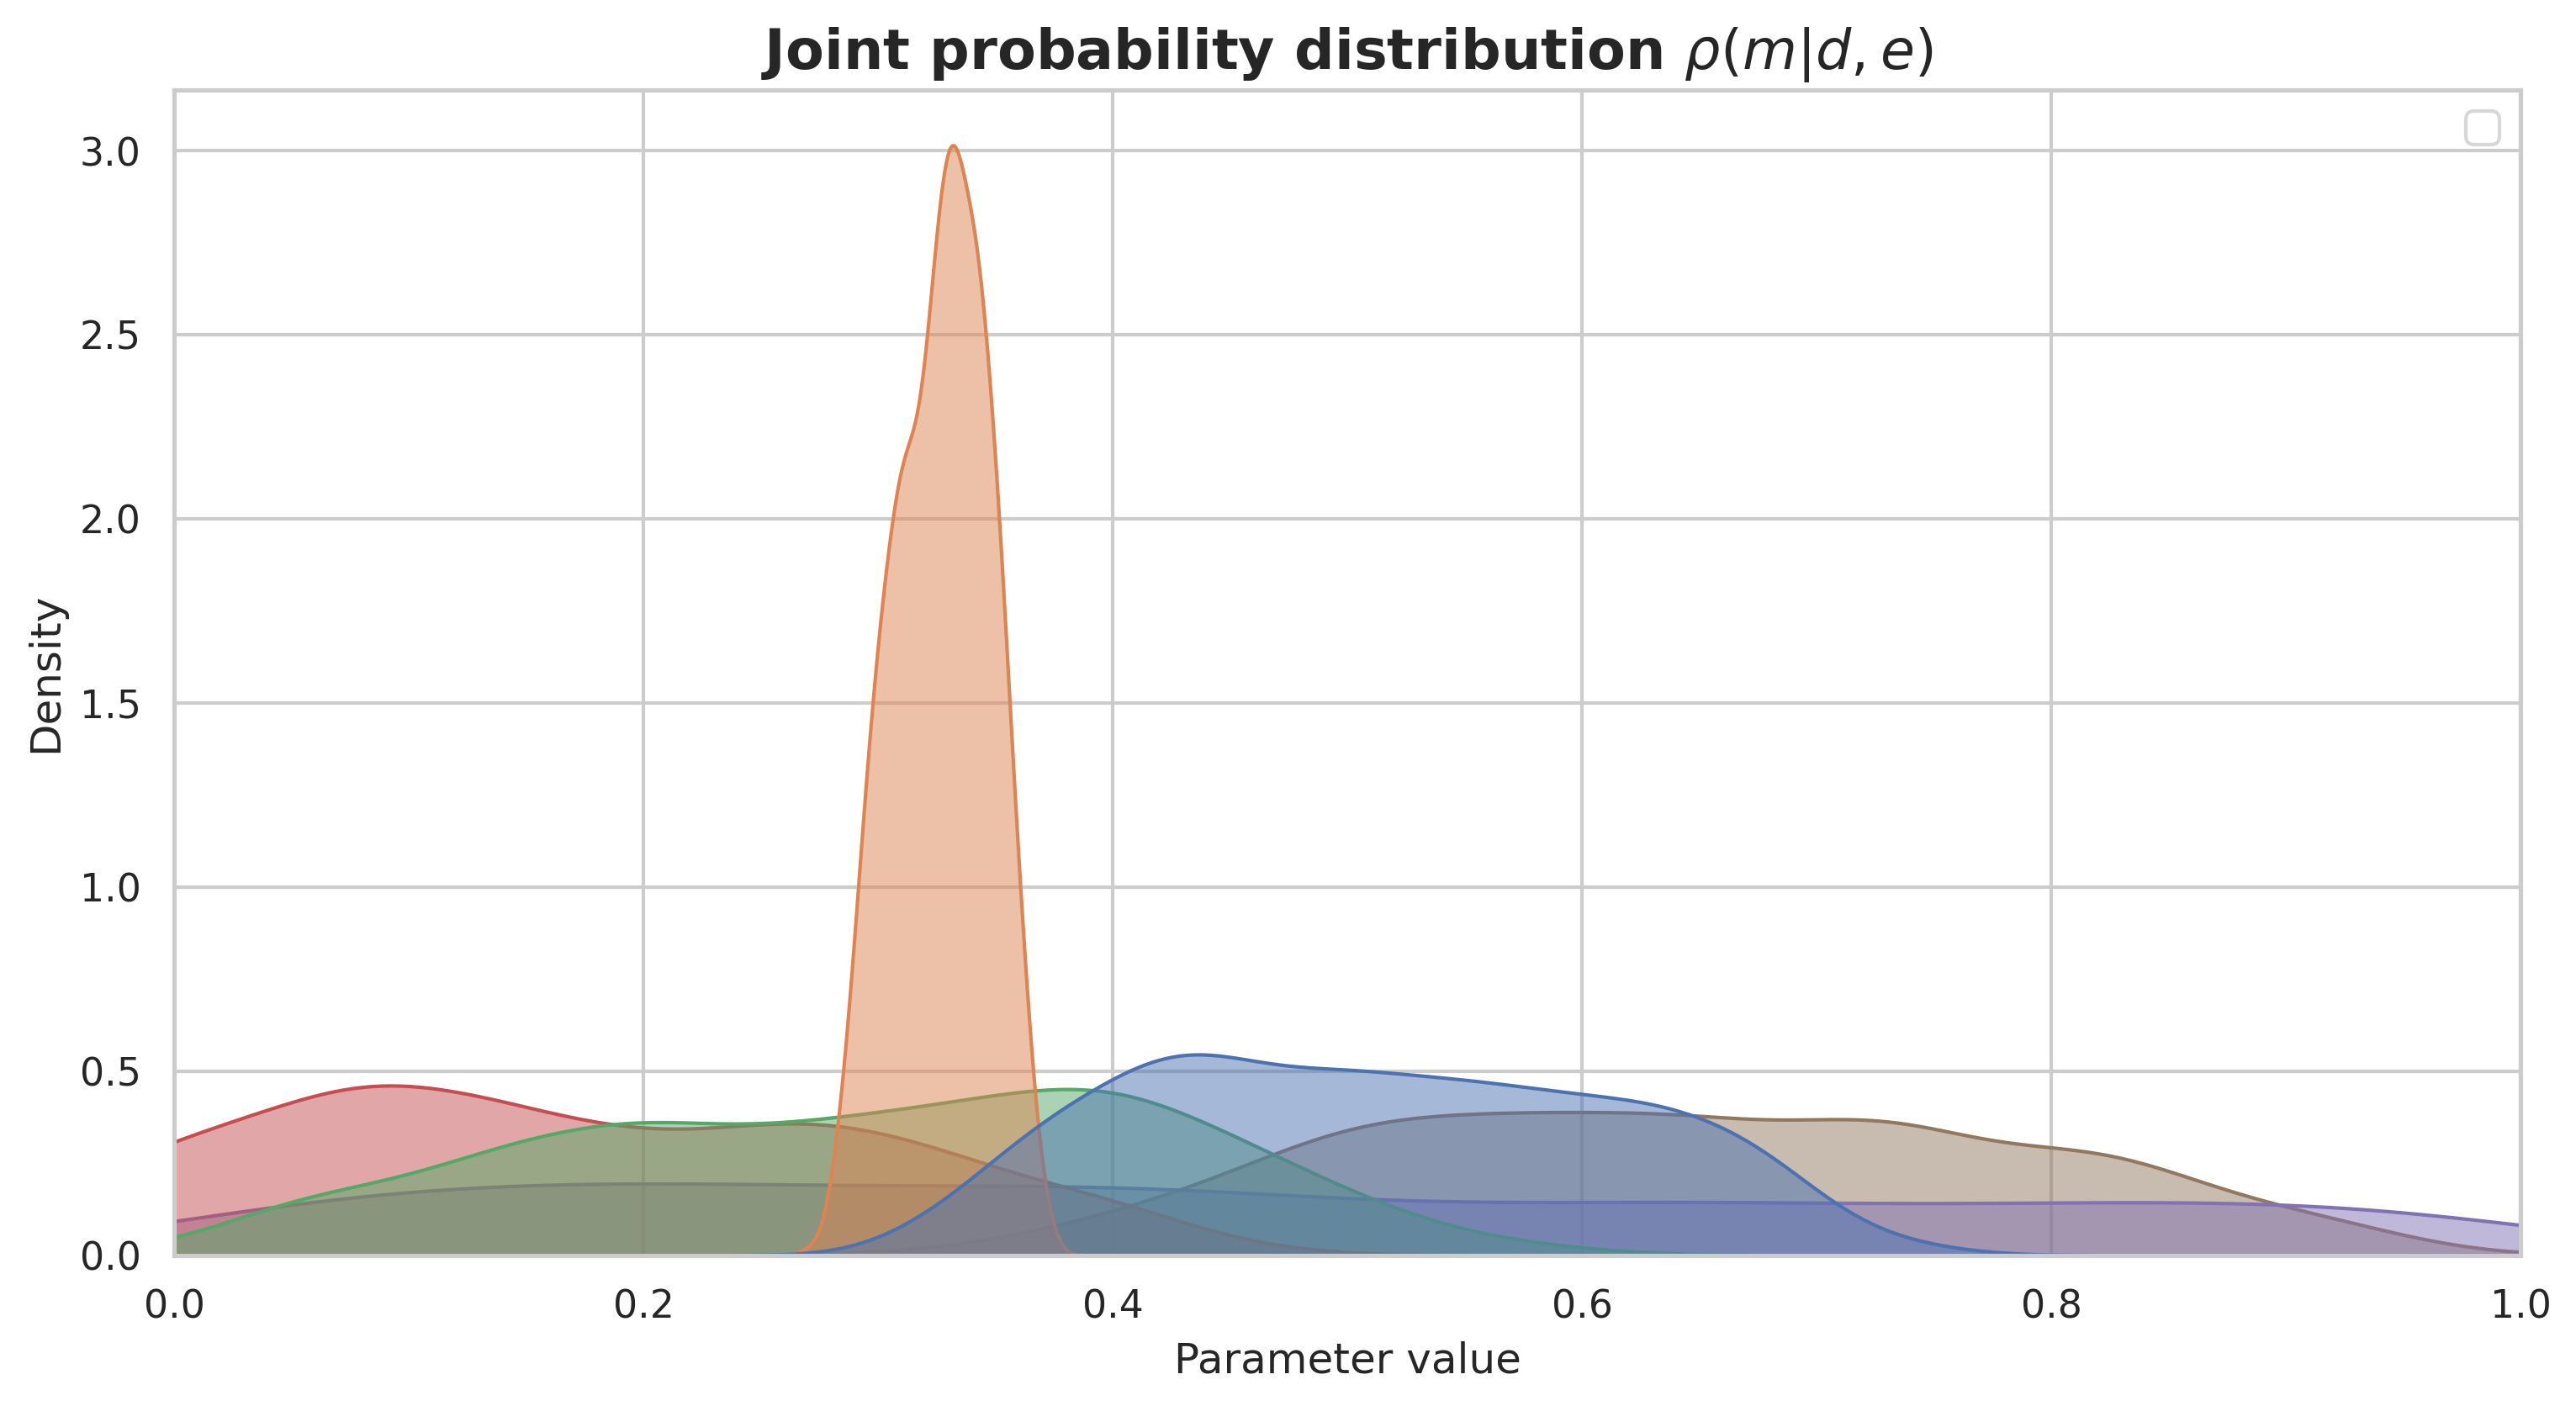

0.12857947 0.06061182


In [39]:
m0 =np.random.uniform(size=6)
m = [0.4, 0.3, 0.3, 0.1, 0.15, 0.6]
e = np.linspace(1,3,4)
d = d_by_m_e(m ,e).flatten()
m0 = jnp.array(m0).reshape(1,-1)
m = jnp.array(m).reshape(1,-1)
e = jnp.array(e).reshape(1,-1)
d = jnp.array(d).reshape(1,-1)
dim = m[0].shape[0] + e[0].shape[0] + d[0].shape[0]
print(dim)

def ode_function(t, m, d, e):
    m = m.reshape(1, -1)
    t = jnp.array(t).reshape(1,-1)
    inputs = jnp.concatenate([m, d, e, t], axis=1)
    return predict(params, inputs)[0]


solution = solve_ivp(ode_function, t_span=[0, 1], y0=m0[0], t_eval=None, args=(d, e))
d_pred = d_by_m_e(solution.y[:, -1],e[0]).flatten()
diff_norm = jnp.linalg.norm(d - d_pred) / jnp.linalg.norm(d)

print(f'm_pred = {solution.y[:, -1]}')
print(f'd = {d}')
print(f'd_pred = {d_pred}')
print(f'diff norm = {diff_norm}')

errors = []
sols = []

for i in tqdm(range(1000)):
    m = [0.4, 0.3, 0.3, 0.1, 0.15, 0.6]
    e = np.linspace(1,3,4)
    d = d_by_m_e(m ,e).flatten()
    m0 = jnp.array(np.random.uniform(size=6)).reshape(1,-1)
    m = jnp.array(m).reshape(1,-1)
    e = jnp.array(e).reshape(1,-1)
    d = jnp.array(d).reshape(1,-1)
    solution = solve_ivp(ode_function, t_span=[0, 1], y0=m0[0], t_eval=None, args=(d, e))
    d_pred = d_by_m_e(solution.y[:, -1],e[0]).flatten()
    sols.append(solution.y[:, -1])
    errors.append(np.linalg.norm(d - d_pred) / np.linalg.norm(d))

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df = pd.DataFrame(sols, columns = [fr'$\beta_1$', fr'$\alpha', fr'$\gamma^r$', fr'$\gamma^d_1$', fr'$\beta_2$', fr'$\gamma^d_2$'])

plt.figure(dpi=300, figsize=(12,6))
sns.kdeplot(df, fill=True, alpha=0.5, common_norm=True)
plt.title(fr'Joint probability distribution $\rho(m|d,e)$', fontsize=16, fontweight='bold')
plt.xlabel('Parameter value')
plt.legend(fontsize=12, loc='best')
plt.xlim(0,1)
plt.savefig(f'{savedir}/seir_25p.png')
plt.show()

print(np.mean(errors), np.std(errors))